In [1]:
%matplotlib inline
from webutils import WebClient
import matplotlib.pyplot as plt
import json

In [2]:
import timeseries as ts
import numpy as np
from scipy.stats import norm

# m is the mean, s is the standard deviation, and j is the jitter
# the meta just fills in values for order and blarg from the schema
def tsmaker(m, s, j):
    "returns metadata and a time series in the shape of a jittered normal"
    meta={}
    meta['order'] = int(np.random.choice([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]))
    meta['blarg'] = int(np.random.choice([1, 2]))
    t = np.arange(0.0, 1.0, 1/1024)
    v = norm.pdf(t, m, s) + j*np.random.randn(1024)
    return meta, ts.TimeSeries(t, v)

In [3]:
## remember to start the server and webserver
## python go_server.py -len 1024 -vps 10 &
## python go_webserver.py &

# w = WebClient('http://localhost:8080')
w = WebClient('http://www.adjch.me:8080')

r = w.add_trigger('junk', 'insert_ts', None, 'db:one:ts')
assert r.status_code == 200

r = w.add_trigger('stats', 'insert_ts', ['mean', 'std'], None)
assert r.status_code == 200


In [4]:
N_ts = 100
N_vp = 10

# choose 5 distinct vantage point time series
vpkeys = ["ts-{}".format(i) for i in np.random.choice(range(N_ts), size=N_vp, replace=False)]


#Set up 50 time series
mus = np.random.uniform(low=0.0, high=1.0, size=N_ts)
sigs = np.random.uniform(low=0.05, high=0.4, size=N_ts)
jits = np.random.uniform(low=0.05, high=0.2, size=N_ts)


# dictionaries for time series and their metadata
tsdict={}
metadict={}
for i, m, s, j in zip(range(N_ts), mus, sigs, jits):
    meta, tsrs = tsmaker(m, s, j)
    # the primary key format is ts-1, ts-2, etc
    pk = "ts-{}".format(i)
    tsdict[pk] = tsrs
    meta['vp'] = False # augment metadata with a boolean asking if this is a  VP.
    metadict[pk] = meta

In [5]:
for i in range(N_vp):
    # add 5 triggers to upsert distances to these vantage points
    w.add_trigger('corr', 'insert_ts', ["d_vp-{}".format(i)], tsdict[vpkeys[i]])
    # change the metadata for the vantage points to have meta['vp']=True
    metadict[vpkeys[i]]['vp']=True
# Having set up the triggers, now inser the time series, and upsert the metadata

In [6]:
for k in tsdict:
    w.insert_ts(k, tsdict[k])
    w.upsert_meta(k, metadict[k])

print("UPSERTS FINISHED")

UPSERTS FINISHED


In [26]:
print(w.select().content)
print(w.select({'order':1}).content)
print(w.select({'order':{'>=':1}},['pk','order']).content)
print(w.select({'order':{'>=':1}},['pk','order'],{'sort_by':'+pk'}).content)

# w.select('akhil').content

b'{"ts-86": {}, "ts-20": {}, "ts-49": {}, "ts-58": {}, "ts-12": {}, "ts-46": {}, "ts-47": {}, "ts-82": {}, "ts-42": {}, "ts-39": {}, "ts-54": {}, "ts-96": {}, "ts-2": {}, "ts-53": {}, "ts-59": {}, "ts-6": {}, "ts-38": {}, "ts-28": {}, "ts-41": {}, "ts-85": {}, "ts-40": {}, "ts-25": {}, "ts-56": {}, "ts-62": {}, "ts-14": {}, "ts-66": {}, "ts-57": {}, "ts-64": {}, "ts-70": {}, "ts-88": {}, "ts-15": {}, "ts-73": {}, "ts-94": {}, "ts-71": {}, "ts-17": {}, "ts-79": {}, "ts-33": {}, "ts-97": {}, "ts-50": {}, "ts-43": {}, "ts-36": {}, "ts-83": {}, "ts-19": {}, "ts-13": {}, "ts-98": {}, "ts-60": {}, "ts-32": {}, "ts-7": {}, "ts-63": {}, "ts-34": {}, "ts-91": {}, "ts-51": {}, "ts-4": {}, "ts-90": {}, "ts-80": {}, "ts-75": {}, "ts-99": {}, "ts-22": {}, "ts-26": {}, "ts-3": {}, "ts-35": {}, "ts-16": {}, "ts-9": {}, "ts-95": {}, "ts-44": {}, "ts-77": {}, "ts-81": {}, "ts-10": {}, "ts-52": {}, "ts-24": {}, "ts-1": {}, "ts-76": {}, "ts-45": {}, "ts-21": {}, "ts-74": {}, "ts-72": {}, "ts-67": {}, "ts

In [24]:
w.select(additional={'sort_by':'+pk','limit':100}).content

b'null'

In [10]:
print('------now computing vantage point stuff---------------------')
print("VPS", vpkeys)

#we first create a query time series.
_, query = tsmaker(0.5, 0.2, 0.1)

------now computing vantage point stuff---------------------
VPS ['ts-92', 'ts-38', 'ts-6', 'ts-60', 'ts-68', 'ts-0', 'ts-67', 'ts-8', 'ts-70', 'ts-48']


In [11]:

# Step 1: in the vpdist key, get  distances from query to vantage points
# this is an augmented select
vpdist = {}
for v in vpkeys:
    r = w.augselect('corr','d',{'pk': v},None,query.to_json())
    results = json.loads(r.content.decode('utf-8'))
    vpdist[v] = results[v]['d']

vpdist

{'ts-0': 0.5726094783918056,
 'ts-38': 0.4659108717816778,
 'ts-48': 0.6043198562015283,
 'ts-6': 0.41453900127753723,
 'ts-60': 0.25023433523711064,
 'ts-67': 0.8979469954364052,
 'ts-68': 0.36000195920704403,
 'ts-70': 0.736221275622491,
 'ts-8': 0.6333787536587037,
 'ts-92': 0.8372454333457265}

VP DIST
{'ts-68': 0.36000195920704403, 'ts-67': 0.8979469954364052, 'ts-48': 0.6043198562015283, 'ts-60': 0.25023433523711064, 'ts-38': 0.4659108717816778, 'ts-6': 0.41453900127753723, 'ts-8': 0.6333787536587037, 'ts-70': 0.736221275622491, 'ts-0': 0.5726094783918056, 'ts-92': 0.8372454333457265}


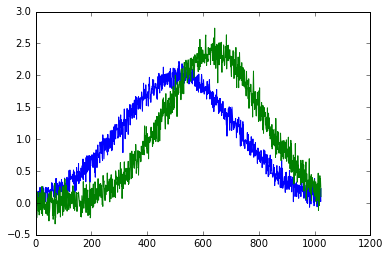

In [12]:
#1b: choose the lowest distance vantage point
# you can do this in local code
print("VP DIST")
print(vpdist)
closest_vpk = min(vpkeys,key=lambda v:vpdist[v])
closest_vpk_dist_col = 'd_vp-' + str(vpkeys.index(closest_vpk))

# Step 2: find all time series within 2*d(query, nearest_vp_to_query)
#this is an augmented select to the same proc in correlation

where_dict = {closest_vpk_dist_col: {'<=': 2*vpdist[closest_vpk]}}
r = w.augselect('corr','d',where_dict,arg=query)
results = json.loads(r.content.decode('utf-8'))

#2b: find the smallest distance amongst this ( or k smallest)
#you can do this in local code
nearestwanted = min(results.keys(),key=lambda p: results[p]['d'])

plt.plot(query)
plt.plot(tsdict[nearestwanted])


In [14]:
r = w.delete_ts(nearestwanted)
r.content.decode('utf-8')

'"WriteSuccessful"'

In [13]:
r = w.find_similar(query,vpkeys)
results = json.loads(r.content.decode('utf-8'))
results

{'ts-74': 0.1655038931037793}

In [14]:
nearestwanted

'ts-74'